In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve
)

from src.data import load_adult, preprocess_adult
from src.preprocessing import make_preprocessor
from src.models.logistic import run_logistic, cross_validate_logistic

sns.set_style("whitegrid")

In [107]:
X, y = load_adult()
X_train, X_test, y_train, y_test, cat_cols, num_cols = preprocess_adult(X, y)

preprocessor = make_preprocessor(cat_cols, num_cols)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (39073, 14)
Test size: (9769, 14)


In [108]:
baseline = run_logistic(
    X_train, X_test, y_train, y_test,
    preprocessor
)
print(baseline["report"])



Standard Classification Report (@ Threshold 0.5):
              precision    recall  f1-score   support

           0     0.8808    0.9314    0.9054      7431
           1     0.7331    0.5992    0.6594      2338

    accuracy                         0.8519      9769
   macro avg     0.8069    0.7653    0.7824      9769
weighted avg     0.8454    0.8519    0.8465      9769


---------------------------------------------
Goal-Aligned Ranking Metrics (Threshold-Independent):

           Ranking Metrics
PR-AUC              0.7647
ROC-AUC             0.9059
f05_score           0.7018
---------------------------------------------



In [109]:
l1 = run_logistic(
    X_train, X_test, y_train, y_test,
    preprocessor,
    penalty="l1",
    C=0.1
)

print(l1["report"])



Standard Classification Report (@ Threshold 0.5):
              precision    recall  f1-score   support

           0     0.8791    0.9316    0.9046      7431
           1     0.7318    0.5928    0.6550      2338

    accuracy                         0.8505      9769
   macro avg     0.8054    0.7622    0.7798      9769
weighted avg     0.8439    0.8505    0.8449      9769


---------------------------------------------
Goal-Aligned Ranking Metrics (Threshold-Independent):

           Ranking Metrics
PR-AUC              0.7650
ROC-AUC             0.9058
f05_score           0.6990
---------------------------------------------



In [110]:
balanced = run_logistic(
    X_train, X_test, y_train, y_test,
    preprocessor,
    class_weight="balanced"
)

print(balanced["report"])



Standard Classification Report (@ Threshold 0.5):
              precision    recall  f1-score   support

           0     0.9375    0.8010    0.8639      7431
           1     0.5675    0.8302    0.6742      2338

    accuracy                         0.8080      9769
   macro avg     0.7525    0.8156    0.7690      9769
weighted avg     0.8489    0.8080    0.8185      9769


---------------------------------------------
Goal-Aligned Ranking Metrics (Threshold-Independent):

           Ranking Metrics
PR-AUC              0.7621
ROC-AUC             0.9056
f05_score           0.6059
---------------------------------------------



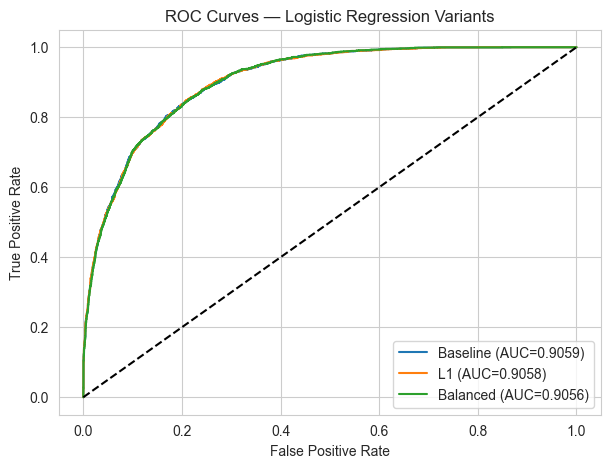

In [111]:
models = {
    "Baseline": baseline,
    "L1": l1,
    "Balanced": balanced
}

plt.figure(figsize=(7,5))

for name, result in models.items():
    pipe = result["pipeline"]
    y_score = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_score):.4f})")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Logistic Regression Variants")
plt.legend()
plt.show()


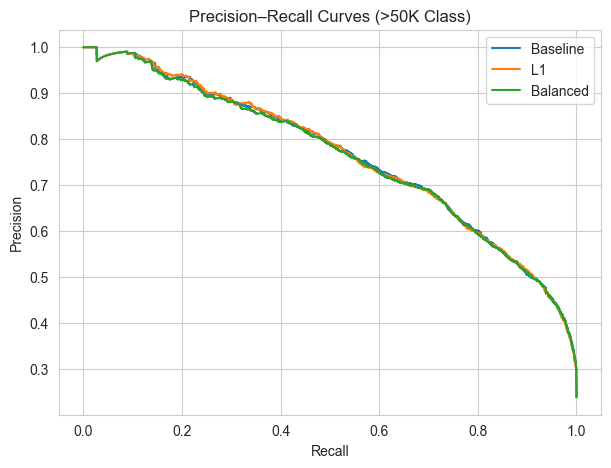

In [112]:
plt.figure(figsize=(7,5))

for name, result in models.items():
    pipe = result["pipeline"]
    y_score = pipe.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (>50K Class)")
plt.legend()
plt.show()


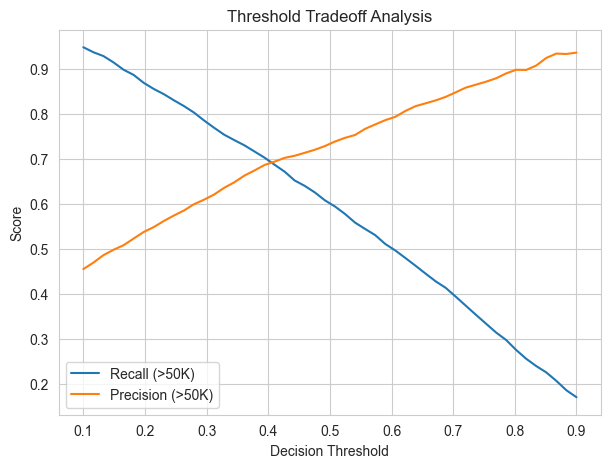

In [113]:
pipe = baseline["pipeline"]
y_scores = pipe.predict_proba(X_test)[:,1]

thresholds = np.linspace(0.1, 0.9, 50)
recalls = []
precisions = []

for t in thresholds:
    preds = (y_scores >= t).astype(int)
    report = classification_report(y_test, preds, output_dict=True)
    recalls.append(report["1"]["recall"])
    precisions.append(report["1"]["precision"])

plt.figure(figsize=(7,5))
plt.plot(thresholds, recalls, label="Recall (>50K)")
plt.plot(thresholds, precisions, label="Precision (>50K)")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Threshold Tradeoff Analysis")
plt.legend()
plt.show()


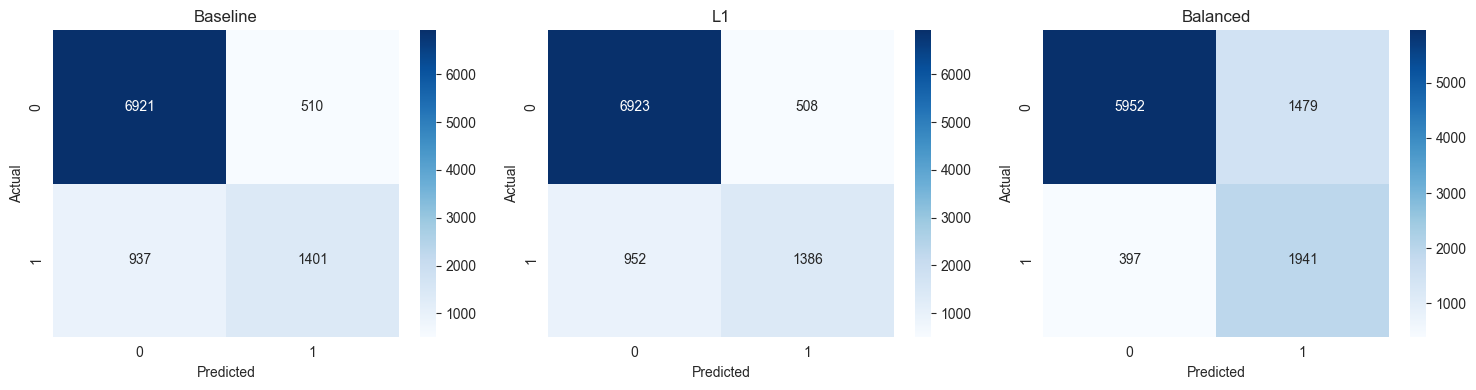

In [114]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

for ax, (name, result) in zip(axes, models.items()):
    pipe = result["pipeline"]
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


Baseline mean PR-AUC: 0.7663, std: 0.0043
L1 mean PR-AUC: 0.7653, std: 0.0045
L1 mean PR-AUC: 0.7653, std: 0.0045
Balanced mean PR-AUC: 0.7645, std: 0.0039
Balanced mean PR-AUC: 0.7645, std: 0.0039


Text(0.5, 1.0, '5-Fold Cross-Validation Comparison of Logistic Regression Variants')

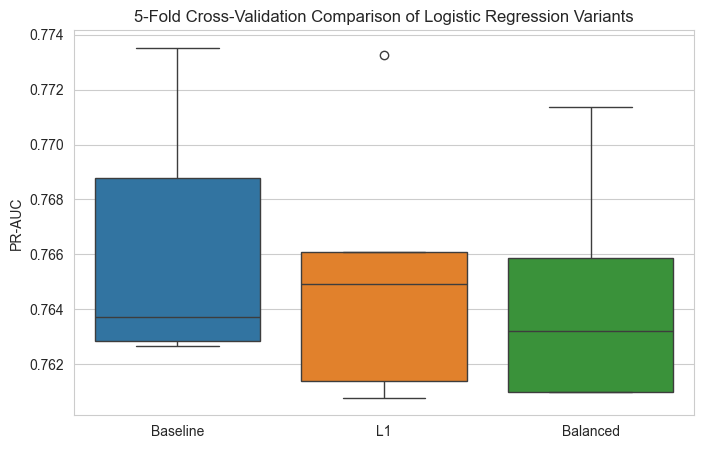

In [121]:
models_for_cv = {
    "Baseline": baseline["pipeline"],
    "L1": l1["pipeline"],
    "Balanced": balanced["pipeline"]
}

cv_results = {}
for name, pipe in models_for_cv.items():
    # Note: cross_validate_logistic defaults to scoring='average_precision' (PR-AUC)
    scores = cross_validate_logistic(pipe, X_train, y_train, cv=5)
    cv_results[name] = scores
    # FIX: Changed ROC-AUC to PR-AUC in the print message
    print(f"{name} mean PR-AUC: {scores.mean():.4f}, std: {scores.std():.4f}")

# Boxplot comparison
plt.figure(figsize=(8,5))
sns.boxplot(data=pd.DataFrame(cv_results))
plt.ylabel("PR-AUC")
plt.title("5-Fold Cross-Validation Comparison of Logistic Regression Variants")

Logistic regression provides a strong baseline with ROC-AUC above 0.9, indicating substantial linear signal in the data. However, error analysis shows that the default decision threshold underpredicts high-income individuals. Regularization affects model sparsity but not ranking performance significantly. Class-weighted logistic regression improves recall for the minority class at the cost of precision, highlighting an inherent tradeoff due to class imbalance. These limitations motivate exploration of more expressive nonlinear models